# Финальный проект. Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. В моём распоряжении собранные командой оператора персональные данные о некоторых клиентах, информация об их тарифах и договорах. Данные расположены в 4 разных датасетах.

### **Подробнее про предоставляемые услуги:**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### **Задача** 
Подготовить модель, предсказывающую уход клиента. Определить параметры, влияющие на решение клиента об уходе. 

### **План работы**

1. Знакомство с данными

1.1. Загрузка датасетов

1.2. Исследование каждого датасета

2. Предобработка

2.1. Обработка пропусков

2.2. Поиск и обработка выбросов

2.3. Поиск и обработка дубликатов

2.4. Объединение датасетов

2.4. Отбор и создание новых признаков

2.5. Разделение данных на обучающую и тестоую выборки

2.6. Кодирование

2.7. Масштабирование

3. Машинное обучение

3.1. Выбор моделей

3.2. Подбор гиперпараметров

3.3. Выбор лучшей модели

4. Проверка лучшей модели на тестовой выборке

5. Исследование важности признаков 

6. Вывод исследования 

### **Вопросы**

1. Правильно ли я понимаю, что для обучения нас нужны лишь те люди, которые уже разорвали контракт? А те, кто до сих пор не разорвали, как раз и являются объктами для предсказания, уйдут они или нет? 

2. Изучая доительность договоров, я обнаружил, что были такие, которые длились ровно 1, 3, или 4 года. Чем это может быть вызвано, почему ровно год, 3 или 4? Я могу предположить, что это связано с типом оплаты.

# Знакомство с данными 

In [1]:
!pip install phik -q


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install imblearn -q


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik.report import correlation_report, plot_correlation_matrix

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 100423

### 1. Первый датасет - *contract_new.csv* - информация о договорах

In [5]:
contract_data = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет, имеем 7043 объекта. 

*customerID*	- код клиента

*BeginDate*	- дата подписания договора

*EndDate*	- дата окончания действия договора

*Type*	- тип оплаты

*PaperlessBilling*	- электронный чек

*PaymentMethod*	- способ расчёта

*MonthlyCharges* - плата в месяц

*TotalCharges* - плата за весь период с момента подписания договора, однако не совсем понятно, как это высчитывается


Типы колонок неверные, иправим:

In [7]:
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'])

При попытке сменить тип столбца *TotalCharges* на float выяснилось, что среди значений в столбце есть пустые строки. Это нужно исправить:

In [8]:
contract_data[contract_data['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Оказывается дело в том, что клиенты с таким значением новые, и еще ни разу не платили, поэтому и общая сумма выплат у них нулевая. Не уверен, что такие клиенты вообще необходимы для анализа, стоит уточнить этот момент. Пока заменим пустое значение на 0 и сменим тип столбца:

In [9]:
contract_data.loc[contract_data[contract_data['TotalCharges'] == ' '].index, 'TotalCharges'] = 0
contract_data['TotalCharges'] = contract_data['TotalCharges'].astype('float64')

Теперь подробнее по интересным столбцам:

1. *BeginDate* и *EndDate*

In [10]:
contract_data['year_begin'] = contract_data['BeginDate'].dt.to_period('Y')
year_dist = contract_data.groupby('year_begin')['customerID'].count()

In [11]:
departed_contract = contract_data[contract_data.EndDate != 'No']
departed_contract['EndDate'] = pd.to_datetime(departed_contract['EndDate'])
departed_contract['year_departed'] = departed_contract['EndDate'].dt.to_period('Y')
year_departed = departed_contract.groupby('year_departed')['customerID'].count()

In [12]:
all_year = pd.concat([year_dist, year_departed], axis=1)
all_year.columns = ['Заключенные контракты', 'Расторгнутые контракты']
all_year.reset_index(inplace=True)
all_year = pd.melt(all_year, id_vars="index", var_name="Тип", value_name="count")

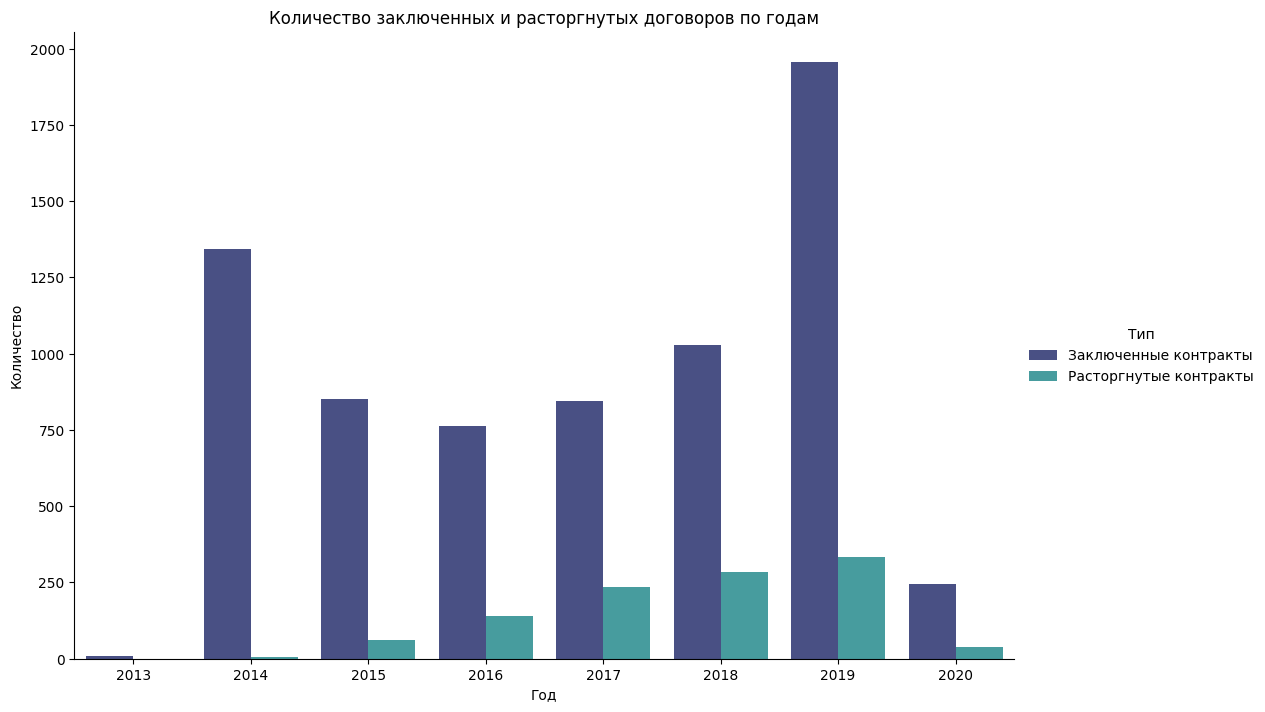

In [13]:
sns.catplot(x='index', y='count', hue='Тип', data=all_year, kind='bar', palette="mako", height=7, aspect=1.5).set(
    title='Количество заключенных и расторгнутых договоров по годам',
    xlabel='Год',
    ylabel='Количество');

Судя по графику, в 2013 было заключено ничтожно малое количество договоров, а в 2014 и 2019 - самое большое количество. Заметна тенденция к тому, что с каждым годом расторгается всё больше договоров, но соотношение заключенных договоров к количеству расторгнутых с каждым годом растёт - хороший знак! 

Интересно посмотреть сколько вообще людей разрывали договор с компанией за всё время:

In [15]:
print(str(round(contract_data[contract_data.EndDate == 'No'].shape[0] / contract_data.shape[0] * 100, 2)) + '%', 
        'договоров не расторгнуто,', 
        str(round(100 - 84.73, 2)) + '%', 
        'договоров расторгнуто за всё время')

84.37% договоров не расторгнуто, 15.27% договоров расторгнуто за всё время


Можно посмотреть на распределение длительности договоров

In [16]:
departed_contract['days_duration'] = (departed_contract.EndDate - departed_contract.BeginDate).dt.days

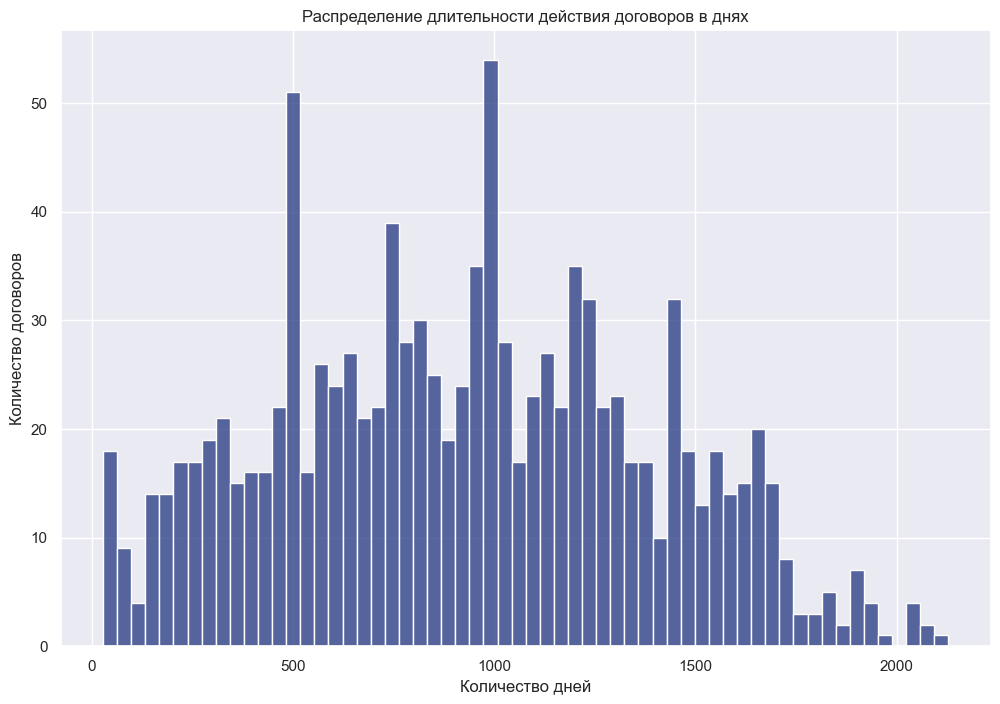

In [17]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.histplot(departed_contract['days_duration'], color='#243782', bins=60).set(
    title='Распределение длительности действия договоров в днях',
    xlabel='Количество дней',
    ylabel='Количество договоров');


Четкие пики заметны на 500 и 100 день. 

In [18]:
val_c = departed_contract['days_duration'].value_counts().reset_index()
val_c.columns = ['Длительность в днях', 'Количество разорванных договоров']
val_c[val_c['Количество разорванных договоров'] > 10]

,Длительность в днях,Количество разорванных договоров
0,1461,18
1,1035,14
2,822,13
3,153,13
4,1096,13
5,792,13
6,365,12
7,1308,12
8,334,12
9,943,11


А в это таблице можно заметить, что много разрывов имеется на 1461 день, то есть спустя ровно 4 года после заключения договора, аналогично много разрывов спустя 1096 дней, то есть 3 года и спустя 365 дней, то есть ровно 1 год.

2. *MonthlyCharges* и *TotalCharges*

In [19]:
contract_data.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


В среднем в месяц пользователь платит 65 у.е., минимум этой суммы - 18 у.е., а  максимум - 118. За всё время компания выручили в среднем 2115 у.е. с одного клиента, максимум - 9221 у.е.

3. *Type*

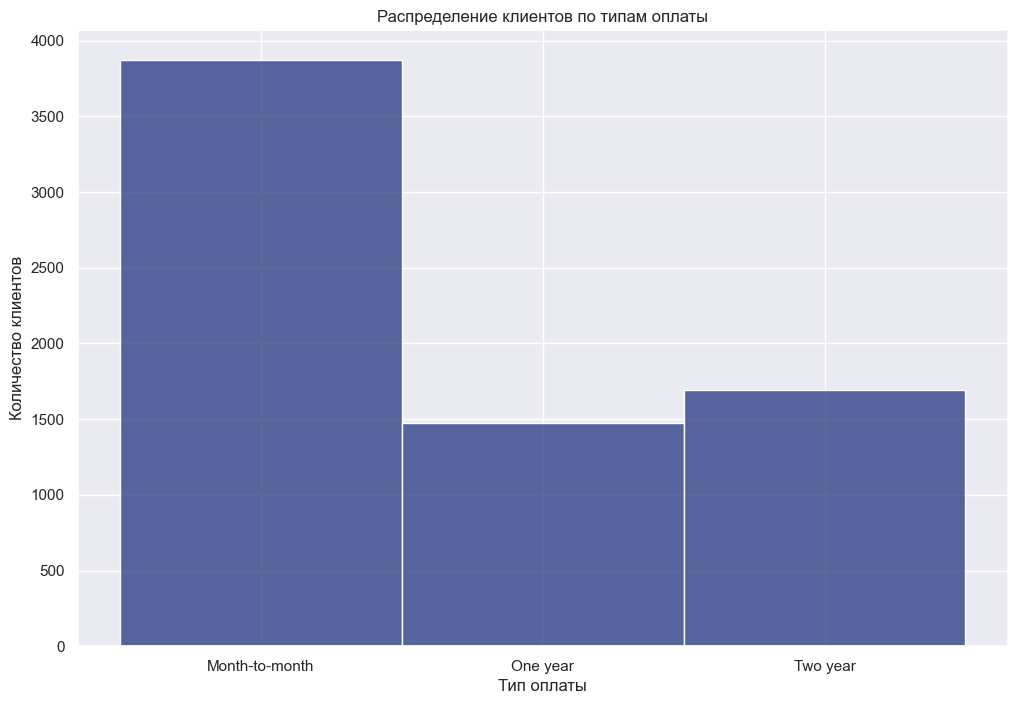

In [20]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.histplot(contract_data['Type'], color='#243782').set(
    title='Распределение клиентов по типам оплаты',
    xlabel='Тип оплаты',
    ylabel='Количество клиентов');

Клиенты примерно в одинаковой мере предпочитают оплату за год и за два, около половины клиентов распредлены между этими двумя типами. Остальная половина польностью использует помесячную оплату. 

### 2. Второй датасет - *internet_new.csv* - информация об интернет - услугах 

In [21]:
internet_data = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [22]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет, с типами столбцов всё гладко. 

### 3. Третий датасет - *personal_new.csv* - персональные данные клиента

In [23]:
personal_data = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
personal_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [24]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет, с типами столбцов всё гладко.  

Посмотрим на распредление характеристик клиентов.

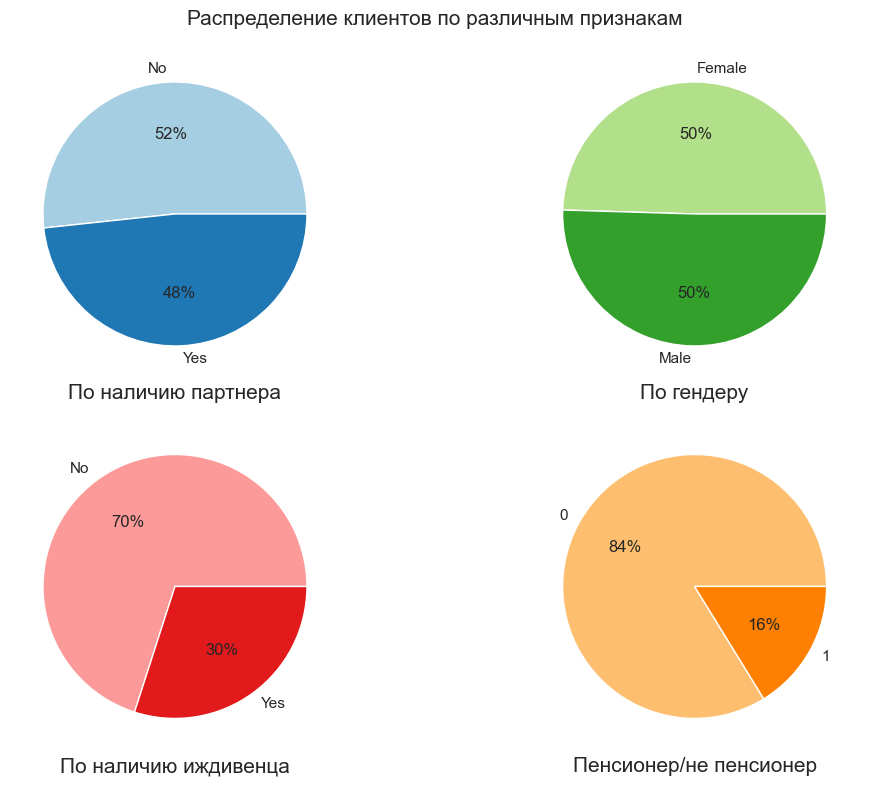

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

personal_data.groupby('Partner').size().plot(kind='pie', autopct='%.0f%%',
                                  colors=sns.color_palette('Paired')[0:2], ax=ax1)
personal_data.groupby('gender').size().plot(kind='pie', autopct='%.0f%%',
                                 colors=sns.color_palette('Paired')[2:4], ax=ax2)
personal_data.groupby('Dependents').size().plot(kind='pie', autopct='%.0f%%',
                                  colors=sns.color_palette('Paired')[4:6], ax=ax3)         
personal_data.groupby('SeniorCitizen').size().plot(kind='pie', autopct='%.0f%%',
                                  colors=sns.color_palette('Paired')[6:8], ax=ax4)                                                    
                                  
ax1.set_xlabel('По наличию партнера', size=15)
ax1.set_ylabel('')
ax2.set_xlabel('По гендеру', size=15)
ax2.set_ylabel('')
ax3.set_xlabel('По наличию иждивенца', size=15)
ax3.set_ylabel('')
ax4.set_xlabel('Пенсионер/не пенсионер', size=15)
ax4.set_ylabel('')
plt.suptitle('Распределение клиентов по различным признакам', size=15)
plt.tight_layout()

Клиенты почти напополам поделились по наличию партнера и по половому соотношению. Лишь 30% клиентов имеют иждивенца, а остальные не имеют. Околок 16% клиентов - пенсионеры. 

### 4. Четвёртый датасет - *phone_new.csv* - информация об услугах телефонии

In [26]:
phone_data = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [27]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков не обнаружено, с типами столбцов всё нормально. 

# Предобработка 

**1. Обработка пропусков**

В первой части проекта выяснилось, что пропусков нет ни в одном датасете, так что этот пункт можно пропустить

**2. Поиск и обработка выбросов**

По сути, выбросы могут быть только в первом датасете, в колонках *MonthlyCharges* и *TotalCharges*, так как больше у нас числовых столбцов нет

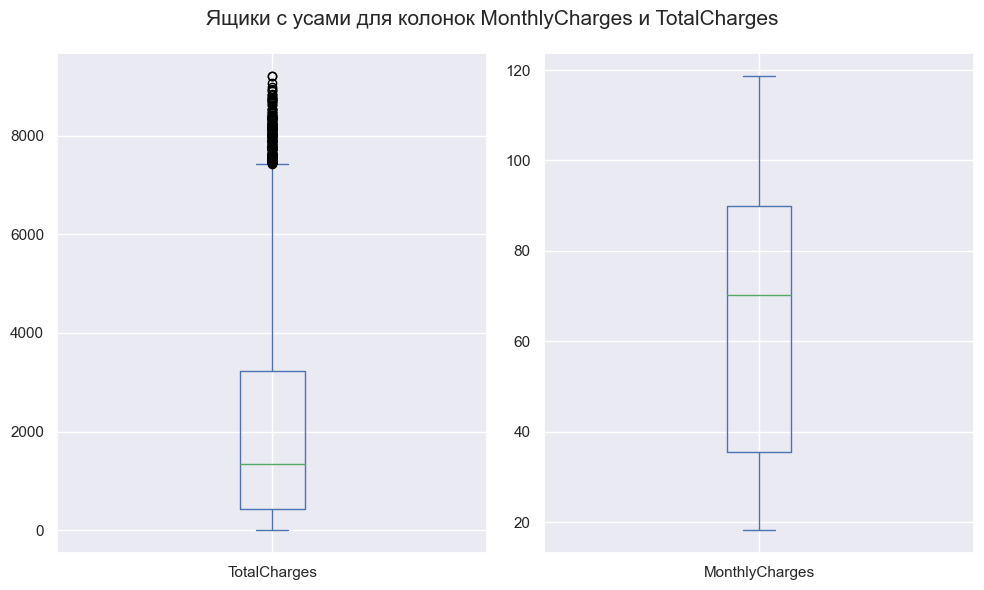

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))

contract_data['TotalCharges'].plot(kind='box', ax=ax1)
contract_data['MonthlyCharges'].plot(kind='box', ax=ax2)
plt.suptitle('Ящики с усами для колонок MonthlyCharges и TotalCharges', size=15)
plt.tight_layout()

График сообщает о наличии выбросов в колонке TotalCharges, но я думаю, что это всё же не выбросы. Эти клиенты вполне могли заплатить столько за весь период предоставления услуг, например если клиент платит 120 у.е. в месяц, при этом он сотрудничает с компанией с самого ее основания, то есть 60 месяцев, то он заплатит уже 7200 у.е., при этом еще стоит учесть плату за доп услуги, которая нам не отображена. 

**3. Поиск дубликатов**

In [29]:
contract_data.duplicated().sum()

0

In [30]:
internet_data.duplicated().sum()

0

In [31]:
personal_data.duplicated().sum()

0

In [32]:
phone_data.duplicated().sum()

0

Дубликатов нет ни в одной из таблиц

**4. Объединение датасетов**

Объединяем *contract_data* и *internet_data* по ключу *customerID*. Для того, чтобы не потерять драгоценные записи в *contract_data* используем left join

In [33]:
data = contract_data.merge(internet_data, on='customerID', how='left')

Аналогично присоединяем к *data* *personal_data* по ключу *customerID*. Здесь используем inner join

In [34]:
data = data.merge(personal_data, on='customerID', how='inner')

По ключу *customerID* присоединяем к *data* *phone_data* методом left join

In [35]:
data = data.merge(phone_data, on='customerID', how='left')

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   year_begin        7043 non-null   period[A-DEC] 
 9   InternetService   5517 non-null   object        
 10  OnlineSecurity    5517 non-null   object        
 11  OnlineBackup      5517 non-null   object        
 12  DeviceProtection  5517 non-null   object        
 13  TechSupport       5517 non-null   object        
 14  StreamingTV       5517 n

Теперь имеем общий датасет, в котором 7043 объекта, и имеются пропуски. От них нужно избавиться. Можно заметить, что пропуски появились из - за объединения таблиц, так как в таблице *internet_data* есть информация не обо всех договорах. Думаю справедливо считать, что, если нет информации о договоре, то у этого пользователя отключены все эти услуги, то есть пропуски необходимо заполнить 0.

In [37]:
data = data.fillna(0)

По графику можно сделать вывод, что 2013 и 2020 года для нас не совсем информативны, справедливо будет избавиться от данных за эти года

In [38]:
data = data.drop(data[data.BeginDate.dt.year == 2013].index, axis=0)
data = data.drop(data[data.BeginDate.dt.year == 2020].index, axis=0)

**5. Отбор и создание новых признаков**

В первой части проекта было обнаружено, что протяженность оказания услуг в днях - очень важный признак, его необходимо добавить

In [39]:
def count_days(row):
    if row['EndDate'] == 'No':
        return (pd.to_datetime('2020-02-01') - row['BeginDate']).days
    else:
        return (pd.to_datetime(row['EndDate']) - row['BeginDate']).days
data['Days'] = data.apply(count_days, axis=1)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6791 entries, 1 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        6791 non-null   object        
 1   BeginDate         6791 non-null   datetime64[ns]
 2   EndDate           6791 non-null   object        
 3   Type              6791 non-null   object        
 4   PaperlessBilling  6791 non-null   object        
 5   PaymentMethod     6791 non-null   object        
 6   MonthlyCharges    6791 non-null   float64       
 7   TotalCharges      6791 non-null   float64       
 8   year_begin        6791 non-null   period[A-DEC] 
 9   InternetService   6791 non-null   object        
 10  OnlineSecurity    6791 non-null   object        
 11  OnlineBackup      6791 non-null   object        
 12  DeviceProtection  6791 non-null   object        
 13  TechSupport       6791 non-null   object        
 14  StreamingTV       6791 n

Отлично! Теперь необходимо удалить вспомогательный столбец *year_begin* и выделить целевую перемнную из столбцов *BeginDate* и *EndDate*, затем их тоже можно будет удалить. Также стоит удалить столбец *customerID*, он никакой информации не предоставляет.

In [41]:
data['is_gone'] = data['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

In [42]:
data = data.drop(['BeginDate', 'EndDate', 'year_begin', 'customerID'], axis=1)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6791 entries, 1 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6791 non-null   object 
 1   PaperlessBilling  6791 non-null   object 
 2   PaymentMethod     6791 non-null   object 
 3   MonthlyCharges    6791 non-null   float64
 4   TotalCharges      6791 non-null   float64
 5   InternetService   6791 non-null   object 
 6   OnlineSecurity    6791 non-null   object 
 7   OnlineBackup      6791 non-null   object 
 8   DeviceProtection  6791 non-null   object 
 9   TechSupport       6791 non-null   object 
 10  StreamingTV       6791 non-null   object 
 11  StreamingMovies   6791 non-null   object 
 12  gender            6791 non-null   object 
 13  SeniorCitizen     6791 non-null   int64  
 14  Partner           6791 non-null   object 
 15  Dependents        6791 non-null   object 
 16  MultipleLines     6791 non-null   object 


Добавлен новый столбец *is_gone*, он принимает значение 1, если клиент покинул компанию, и 0 в противном случае.

Заменим все значения 'Yes' на 1, а 'No' на 0

In [44]:
data = data.replace(to_replace='No', value=0)
data = data.replace(to_replace='Yes', value=1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Days,is_gone
1,One year,0,Mailed check,56.95,2071.84,DSL,1,0,1,0,0,0,Male,0,0,0,0,1036,0
2,Month-to-month,1,Mailed check,53.85,226.17,DSL,1,1,0,0,0,0,Male,0,0,0,0,123,0
3,One year,0,Bank transfer (automatic),42.30,1960.60,DSL,1,0,1,1,0,0,Male,0,0,0,0,1371,0
4,Month-to-month,1,Electronic check,70.70,353.50,Fiber optic,0,0,0,0,0,0,Female,0,0,0,0,153,0
5,Month-to-month,1,Electronic check,99.65,1150.96,Fiber optic,0,0,1,0,1,1,Female,0,0,0,1,337,0


Построим матрицу корреляции признаков, чтобы сделать вывод от мультиколлинеарности и влиянии некоторых признаков на целевую переменную:

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'Days', 'is_gone']


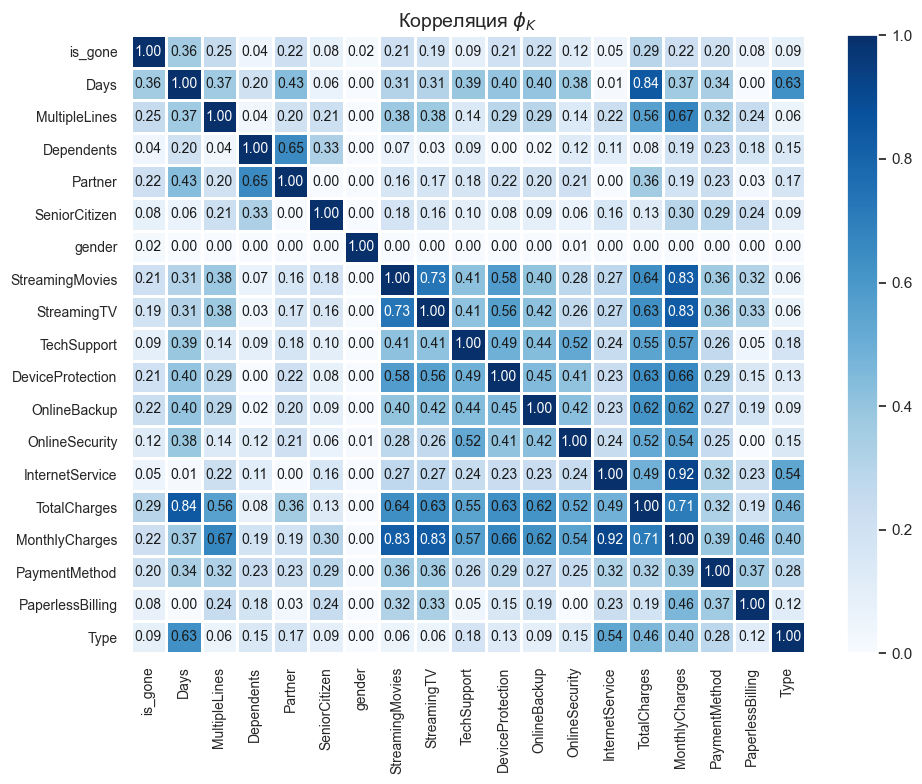

In [45]:
interval_cols = data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8));

*TotalCharges* очень сильно коррелирует с *Days*, что очень логично. Так как *Days* имеет более сильную связь с целевой переменной, то удалим *TotalCharges*.

*Type* сильно коррелиоует с *Days*. Так как *Days* имеет более сильную связь с целевой переменной, то удалим *Type*.

*Dependents* сильно зависит от *Partner*, что тоже справедливо. Удалим *Dependents*

*StreamingTV* и *StreamingMovies* сильно связаны между собой, удалим *StreamingTV*

*StreamingMovies* сильно коррелирует с *MonthlyCharges* - удаляем

*MonthlyCharges* сильно коррелирует почти со всеми признаками из таблички *intenet*, это веское основание для удаления *MonthlyCharges*

In [46]:
data = data.drop(['TotalCharges', 'Type', 'Dependents', 'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'InternetService'], axis=1)

interval columns not set, guessing: ['PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'SeniorCitizen', 'Partner', 'MultipleLines', 'Days', 'is_gone']


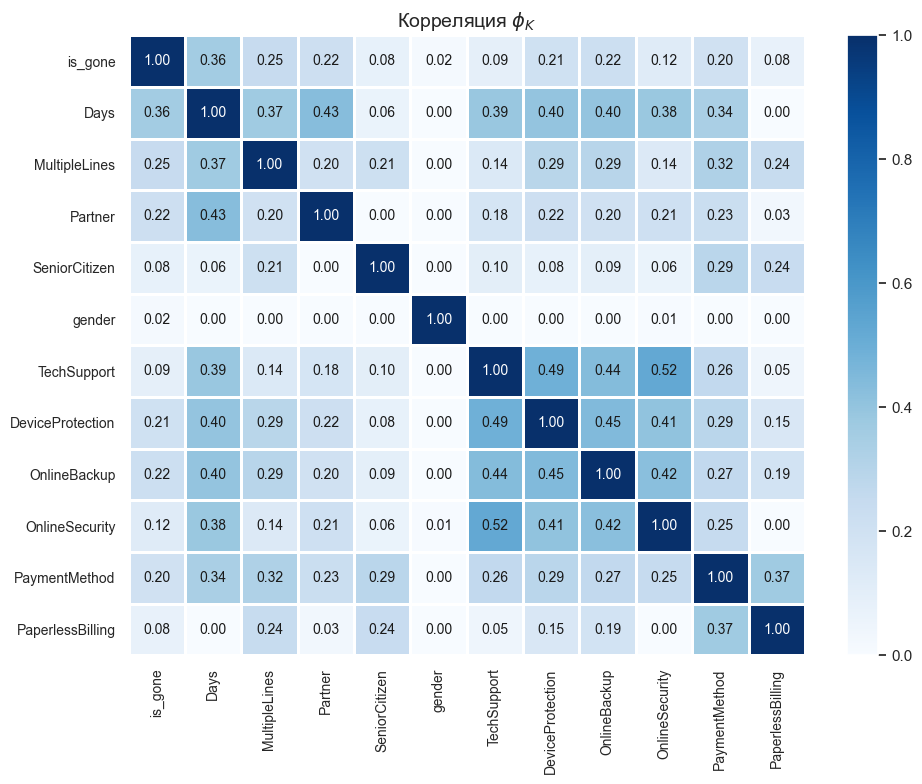

In [47]:
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))

Сильных корреляций не осталось, проблема мультиколлинеарности не должна помещать нам в обучении. На этом этап формирования признаков окончен

**6. Масштабирование и кодирование**

Этапы масштабирования и кодирования размещены в pipeline

In [48]:
num_cols = ['Days']
cat_cols = ['PaymentMethod', 'gender']
bin_cols = ['Partner', 'MultipleLines', 'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'SeniorCitizen']
num_pipe = Pipeline([('scaler', StandardScaler())])

col_pipe = ColumnTransformer([#('num_cols', num_pipe, num_cols), #от масштабирования пришлось избавиться, так как оно не влияло на работу лучшей модели,
                                                                 #но при этом убивало репрезентативность коэфиициентов
                              ('cat_cols', OrdinalEncoder(), cat_cols),
                              ('bin_cols', OneHotEncoder(drop='first'), bin_cols)],
                              remainder='passthrough')
pipeline = make_pipeline(col_pipe)

pipeline.steps.append(('clf', DummyClassifier()))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_cols', OrdinalEncoder(),
                                                  ['PaymentMethod', 'gender']),
                                                 ('bin_cols',
                                                  OneHotEncoder(drop='first'),
                                                  ['Partner', 'MultipleLines',
                                                   'PaperlessBilling',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'SeniorCitizen'])])),
                ('clf', DummyClassifier())])

**7. Разделение на обучающую и тестовую выборку**

In [49]:
target = data['is_gone']
features = data.drop('is_gone', axis=1)

In [50]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

# Обучение моделей

Будем рассматривать три модели: случайный лес, лассо-регрессию, градиентный бустинг

In [51]:
params = [
    {
        'clf': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'clf__n_estimators':  [10, 100, 200, 300],
        'clf__max_depth':  [5, 15, 25, 40],
    },
    
    {
        'clf': [Lasso()],
        'clf__fit_intercept': [True, False],
        'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    },

    {
        'clf': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'clf__n_estimators': [10, 100, 200, 300],
        'clf__learning_rate': [0.001, 0.01, 0.1, 1]
    }
]

grid_first = RandomizedSearchCV(pipeline,
                    param_distributions=params,
                    cv=3,
                    verbose=1,
                    random_state=RANDOM_STATE,
                    scoring='roc_auc',
                    n_jobs=-1)

In [52]:
grid_first.fit(features_train, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_cols',
                                                                               OrdinalEncoder(),
                                                                               ['PaymentMethod',
                                                                                'gender']),
                                                                              ('bin_cols',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Partner',
                                                                                'MultipleLines',
                                                                                'PaperlessBilling',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'SeniorCitizen'...
                                         'clf__max_depth': [5, 15, 25, 40],
                                         'clf__n_estimators': [10, 100, 200,
                                                               300]},
                                        {'clf': [Lasso()],
                                         'clf__alpha': [0.0001, 0.001, 0.01,
                                                        0.1, 1, 10, 100],
                                         'clf__fit_intercept': [True, False]},
                                        {'clf': [GradientBoostingClassifier(n_estimators=300,
                                                                            random_state=100423)],
                                         'clf__learning_rate': [0.001, 0.01,
                                                                0.1, 1],
                                         'clf__n_estimators': [10, 100, 200,
                                                               300]}],
                   random_state=100423, scoring='roc_auc', verbose=1)

In [53]:
grid_first.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_cols', OrdinalEncoder(),
                                                  ['PaymentMethod', 'gender']),
                                                 ('bin_cols',
                                                  OneHotEncoder(drop='first'),
                                                  ['Partner', 'MultipleLines',
                                                   'PaperlessBilling',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'SeniorCitizen'])])),
                ('clf',
                 GradientBoostingClassifier(n_estimators=300,
                                            random_state=100423))])

По итогу работы подбора лучшей моделью стал градиентный бустинг с количеством деревьев 300

# Вычисление результата на тестовой выборке

In [54]:
print('Значение метрики AUC-ROC: ' + str(roc_auc_score(target_test, grid_first.predict_proba(features_test)[:, 1])))

Значение метрики AUC-ROC: 0.9252503033980584


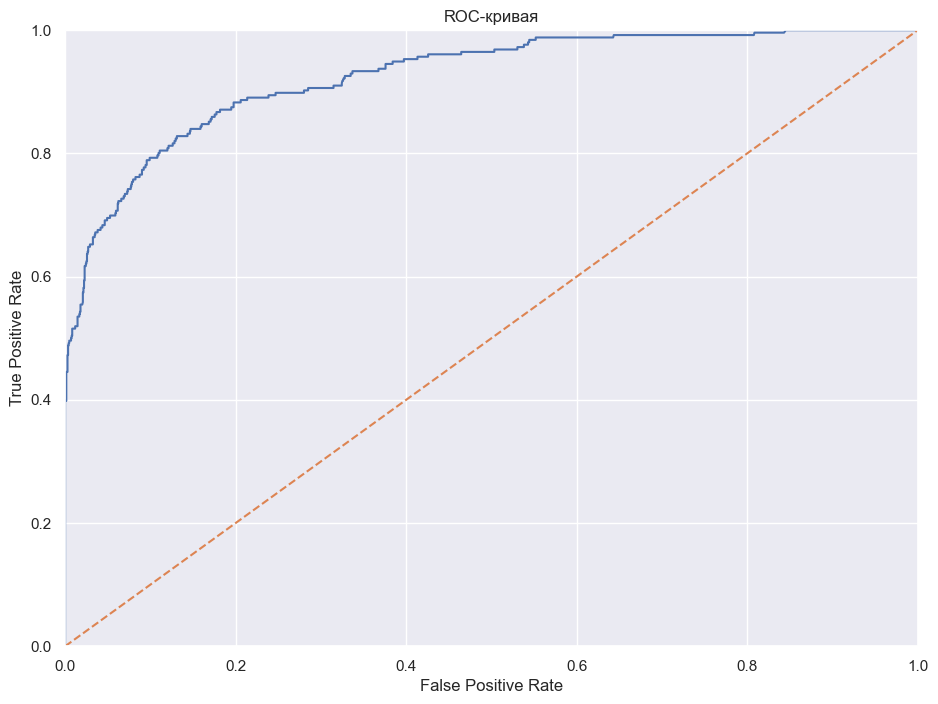

In [55]:
def plot_roc_curve(target_test, predictions):

    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 8))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

plot_roc_curve(target_test, grid_first.predict_proba(features_test)[:, 1])

Получилась неплохая AUC-ROC кривая. Явно высокий Precision и низкий recall. 

In [56]:
pd.DataFrame({'recall': recall_score(target_test, grid_first.predict(features_test)),
'precision': precision_score(target_test, grid_first.predict(features_test))}, index=[0])

,recall,precision
0,0.496094,0.940741


Полученные значения указывают на то, что модель очень редко считает, что клиенты, которые не хотят уходить, хотят уйти, маленький процент FP. Но часто не признаёт клиентов, которые действительно хотят уйти, то есть большой процент FN. С точки зрения формулировки задачи, это плохо, нам бы наверное хотелось работать в обратную сторону, но я думаю такой дисбаланс метрик вызван дисбалансом классов.

# Исследование важности признаков

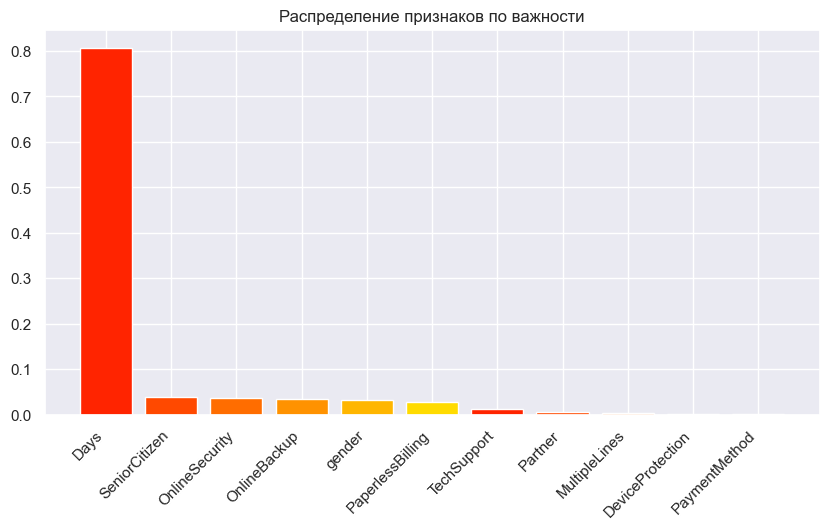

In [57]:
importances = {features_test.columns[i]: grid_first.best_estimator_[-1].feature_importances_[i] for i in range(len(features_test.columns))}
importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 5))
plt.bar(importances.keys(), importances.values(), color=sns.color_palette('autumn'))
plt.xticks(rotation=45, ha='right')
plt.title('Распределение признаков по важности')
plt.show()


Ни один другой признак не показал такой важности, как "Days" - количество дней, прошедших с момента подписания договора. Более, того важность всех других признаков меркнет по сравнению с этим. Получается, что самый главный параметр - количество дней с момента подписания договора, и компании стоит задуматься о предложении определенных бонусов для старых клиентов.

# Вывод исследования 


Изначально я располагал данными, разделенными на 3 датасета, каждый из них хранил конкретную информацию: о признаках контрактов, персональная информация клиентов, информация об используемых услугах.
    
Первым этапом выполнения проекта, естесственно, стало знакомство с данными. Каждый датасет был изучен на наличие пропусков, были рассмотрены распределения признаков, построены некоторые типы графиков, в том числе агрегированные при изучении частоты расторгания и заключения контрактов по годам.   

Учитывая все выявленные особенности, можно было начинать основную работу. Сначала был составлен план, включающий в себя все этапы предобработки, подборки и тестирования моделей, опредления важности признаков. Затем по этому плану я начал готовить данные к построению модели:

- Работа с пропусками. Они оказались в одном датасете, по причине того, что это была информация о новых клиентов, которые еще ни разу не платили;

- Поиск и обработка выбросов и всякого рода аномалий. Так как числовых столбцов в данных не много, то проверке на этом этапе подверглись лишь 2 столбца. Несмотря на то, что ящики с усами сигнализировали о выбросах в этих столбцах, я решил не избавлться от них, так как они имеют место быть. Также было принято избавиться от данных за 2013 и 2020 года(то есть крайние), так как в 2013 почти ничего не происходила, а информация за 2020 год неполная;

- Дубликаты. Дубликатов обнаружено не было, искать неявные дубликаты смысла не было, так как объекты имеют уникальные ключи;

- Объединение датасетов. Так как лишь 2 из 4 датасетов имели одинаковое количество объектов, а объединение проводилось по уникальному ключу, неизбежно образовались пропуски в колонках, связанных с поставляемыми услугами. Так как колонки содержали лишь значения "Yes" и "No" было принято решение заменить пропуски на "No".

- Отбор и создание новых признаков. Основным критерием отбора являлась матрица корреляции. Были удалены все скоррелированные признаки с целью избавления от мультиколлинеарности. Был добавлен новый признак, отвечающий за количество дней с момента подписания договора. Также именно на этом этапе был сформирован целевой признак при помощи столбца, отвечающего за дату ухода. Все столбцы с датой также были удалены;

- Разделение данных. Данные были разделены на обучающую и тестовую выборки, сооношения из размеров 3:1 соответственно;

- Кодирование. Первым делом я заменил все значения "No" в таблице на 0, а "Yes" - на 1. Затем в пайплайне применялся OrdinalEncoder к категориальным столбцам и OneHotEncoder с параметром drop_first=True с целью избегания мультиколлинеарности к бинарным признакам;

- Масштабирование. Масштабирование применяется к данным в пайплайне, только к числовым столбцам. К сожалению, на работу лучшей модели масштабирование не влияло, но зато оно убивало репрезентативность признаков, поэтому было решено не проводить масштабирование;

На этом предобработка данных закончилась.

Следующим этапом был подбор параметров и выбор лучшей модели. Этот этап тоже был реализован внутри пайплайна, за подбор лучшей модели отвечал RandomizedSearchCV. По итогу работы этого этапа лучшей моделью был признан GradientBoostingClassifier с количеством деревьем 300.

Далее модель была протестирована на тестовой выборке. Время предсказания оказалось 0.2 секунды, и полученная метрика AUC-ROC равна 0.925. Получилась неплохая AUC-ROC кривая, recall = 0.5, precision = 0.94. Модель редко ошибочно считает, что клиент хочет уйти, это несомненно плюс. Однако модель редко распознаёт клиентов, которые реально хотят уйти, и это уже не очень решает поставленную задачу. Я думаю, что такое соотношение метрик вызвано дисбалансом классов. 

Последним этапом было установление выжности признаков. Было однозначно выявлено, что ни один признак не может сравниться по важности с искусственно созданным признаком, означающим количество дней, прошедших с момента подписания договора. Это означает, что компании стоит начать деятельность в двух направлениях: 

- Политика удержания старых клиентов с помощью различных акций/бонусов/специальных предложений;

- Ввести новые вид контрактов - долгосрочный, который подписывается сразу на несколько лет, уверен, такое нововведение может повлиять на отток в положительном направлении

В целом весь проект был выполнен в штатном режиме, с опорой на составленный в начале план. Несомненно, в процессе вскрывались подводные камни, например образование пропусков после объединения датасетов, но они были успешно устранены. 
